In [7]:
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
import math
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import os
import json

state_size = 10  # This needs to be set according to your state size
action_size = 3  # sit, buy, sell
memory = deque(maxlen=1000)
inventory = []
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episode_loss = 0

In [8]:
def initialize_model(state_size, action_size):
    model = Sequential()
    model.add(Dense(units=64, input_dim=state_size, activation="relu"))
    model.add(Dense(units=32, activation="relu"))
    model.add(Dense(units=8, activation="relu"))
    model.add(Dense(action_size, activation="linear"))
    model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
    return model

def act(model, state, epsilon, action_size):
    if random.random() <= epsilon:
        return random.randrange(action_size)
    options = model.predict(state)
    return np.argmax(options[0])

def exp_replay(memory, model, batch_size, gamma, epsilon, epsilon_min, epsilon_decay):
    if len(memory) < batch_size:
        return 0  # Return 0 if there's not enough data to process
    
    mini_batch = random.sample(memory, batch_size)
    losses = []

    for state, action, reward, next_state, done in mini_batch:
        target = reward
        if not done:
            target = reward + gamma * np.amax(model.predict(next_state)[0])
        target_f = model.predict(state)
        target_f[0][action] = target
        loss = model.fit(state, target_f, epochs=1, verbose=0).history['loss'][0]
        losses.append(loss)
    
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    
    return np.mean(losses) if losses else 0

def find_latest_checkpoint(model_dir):
    checkpoint_files = [int(f.split('.')[0]) for f in os.listdir(model_dir) if f.endswith('.keras')]
    return max(checkpoint_files) if checkpoint_files else None


In [3]:
def formatPrice(n):
    return("-$" if n<0 else "$")+"{0:.2f}".format(abs(n))

def getStockDataVec(key):
    vec = []
    lines = open(key+".csv","r").read().splitlines()
    for line in lines[1:]:
        vec.append(float(line.split(",")[4]))
    return vec 

def sigmoid(x):
    return 1/(1+math.exp(-x))

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res]) 

In [ ]:
def train_model(stock_name, window_size, episode_count, batch_size):
    data = getStockDataVec(stock_name)
    l = len(data) - 1
    losses = []
    model_dir = "saved_models"
    losses_dir = "loss_file"

    model = initialize_model(window_size, action_size)

    latest_checkpoint = find_latest_checkpoint(model_dir)
    start_episode = 0

    if latest_checkpoint:
        model = load_model(os.path.join(model_dir, f"{latest_checkpoint}.keras"))
        with open(os.path.join(losses_dir, f"losses_{latest_checkpoint}.json"), 'r') as f:
            losses = json.load(f)
        start_episode = latest_checkpoint + 1
        print(f"Resuming from episode {start_episode}")

    for e in tqdm(range(start_episode, episode_count + 1)):
        print(f"Episode {e}/{episode_count}")
        state = getState(data, 0, window_size + 1)
        total_profit = 0
        inventory = []
        episode_loss = 0

        for t in range(l):
            action = act(model, state, epsilon, action_size)
            next_state = getState(data, t + 1, window_size + 1)
            reward = 0

            if action == 1:  # buy
                inventory.append(data[t])
                print("Buy: " + formatPrice(data[t]))
            elif action == 2 and len(inventory) > 0:  # sell
                bought_price = inventory.pop(0)
                reward = max(data[t] - bought_price, 0)
                total_profit += data[t] - bought_price
                print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
            
            done = True if t == l - 1 else False
            memory.append((state, action, reward, next_state, done))
            state = next_state

            if done:
                print("--------------------------------")
                print(f"Total Profit: {formatPrice(total_profit)}")
                print("--------------------------------")

            if len(memory) > batch_size:
                loss = exp_replay(memory, model, batch_size, gamma, epsilon, epsilon_min, epsilon_decay)
                episode_loss += loss

        average_episode_loss = episode_loss / l
        losses.append(average_episode_loss)

        if e % 10 == 0:  # Save every 10 episodes
            model.save(os.path.join(model_dir, f"{e}.keras"))
            loss_file = os.path.join(losses_dir, f"losses_{e}.json")
            with open(loss_file, 'w') as f:
                json.dump(losses, f)


train_model("data/AMZN", 10, 2000, 32)

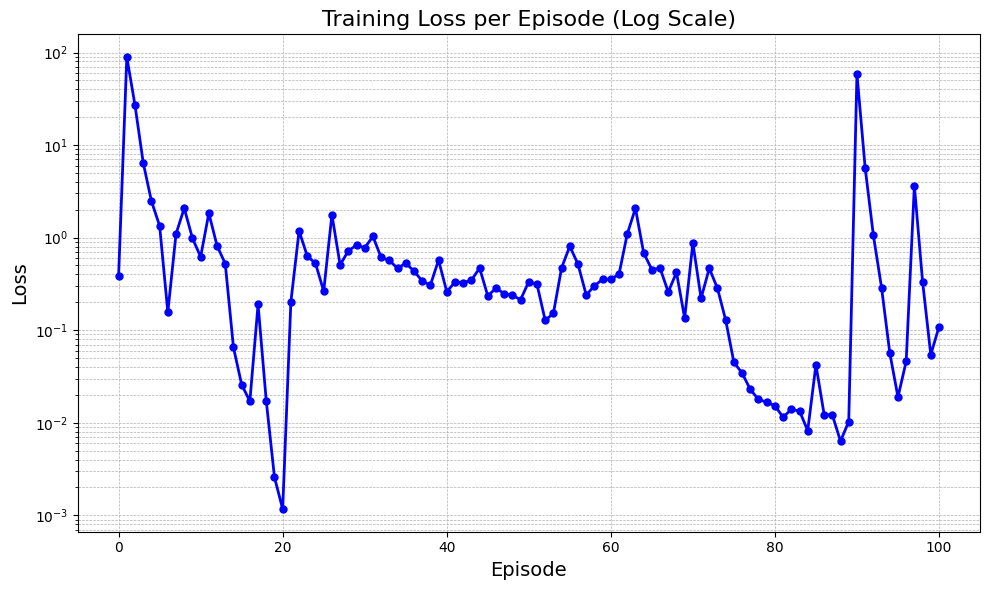

In [60]:
def load_losses_from_file(losses_file):
    with open(losses_file, 'r') as f:
        losses = json.load(f)
    return losses

episode_count = 100
losses_file = f"./loss_file/losses_{episode_count}.json"

losses = load_losses_from_file(losses_file)

plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='blue', markersize=5, linewidth=2)
plt.yscale('log')  # Logarithmic scale for better visibility of small values
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training Loss per Episode (Log Scale)', fontsize=16)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

[137.850006, 138.559998, 138.410004, 140.570007, 137.669998, 135.070007, 133.979996, 133.220001, 134.679993, 134.25, 135.520004, 131.839996, 133.259995, 133.139999, 134.910004, 135.070007, 138.009995, 138.119995, 137.270004, 135.360001, 137.850006, 138.229996, 143.100006, 141.229996, 144.850006, 144.720001, 140.389999, 139.979996, 137.630005, 135.289993, 129.330002, 129.119995, 131.270004, 125.980003, 125.980003, 125.980003, 127.120003, 129.460007, 124.720001, 127.0, 125.959999, 127.959999, 128.259995, 129.479996, 131.830002, 132.330002, 129.789993, 132.550003, 131.470001, 128.130005, 128.399994, 125.169998, 126.559998, 128.559998, 121.389999, 119.57, 127.739998, 132.710007, 133.089996, 137.0, 138.070007, 138.600006, 139.740005, 142.710007, 142.080002, 140.600006, 143.559998, 142.589996, 145.800003, 143.199997, 142.830002, 145.179993, 146.130005, 143.899994, 146.710007, 146.740005, 147.729996, 147.029999, 146.320007, 146.089996, 147.029999, 144.839996, 146.880005, 144.520004, 146.88000

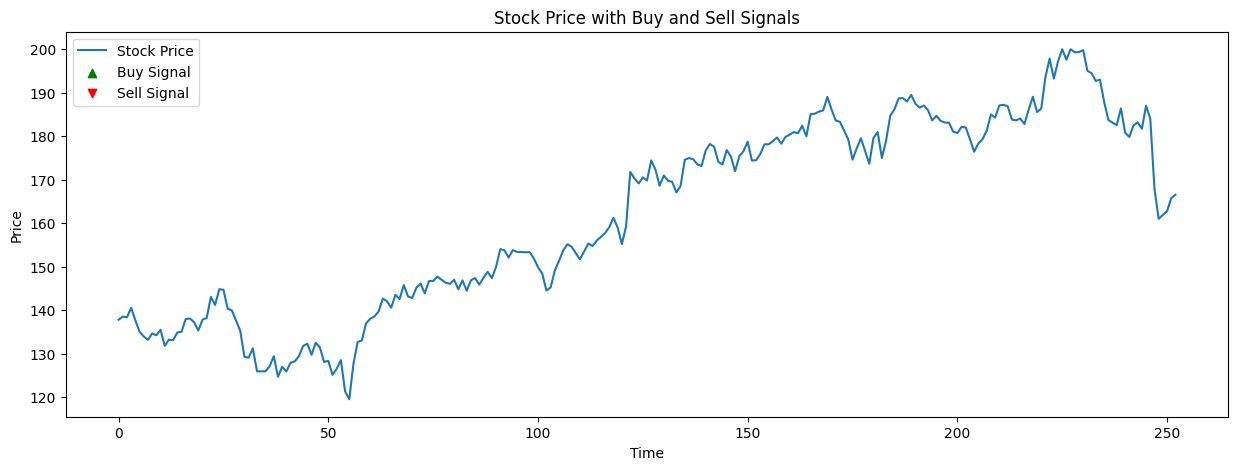

Final Total Profit: $0.00


In [62]:
def initialize_model_for_trading(model_name):
    model = load_model(model_name)
    window_size = model.layers[0].input.shape[1]
    return model, window_size

# Choose an action
def act(model, state, epsilon=0):
    options = model.predict(state)
    return np.argmax(options[0])

# Execute the trading strategy
def execute_trading_strategy(model, data, window_size):
    l = len(data) - 1
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    inventory = []
    memory = []
    
    # For plotting buy/sell signals
    buy_signals = []
    sell_signals = []

    for t in range(l):
        action = act(model, state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1:  # buy
            inventory.append(data[t])
            buy_signals.append((t, data[t]))  # Record buy signal
            print("Buy: " + formatPrice(data[t]))
        elif action == 2 and len(inventory) > 0:  # sell
            bought_price = inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            sell_signals.append((t, data[t]))  # Record sell signal
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print(f"Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            print("Total profit is:", formatPrice(total_profit))

    # Plotting the stock price with buy and sell signals
    plt.figure(figsize=(15, 5))
    plt.plot(data, label='Stock Price')
    buy_points = [p[1] for p in buy_signals]
    buy_times = [p[0] for p in buy_signals]
    sell_points = [p[1] for p in sell_signals]
    sell_times = [p[0] for p in sell_signals]

    plt.scatter(buy_times, buy_points, marker='^', color='green', label='Buy Signal', alpha=1)
    plt.scatter(sell_times, sell_points, marker='v', color='red', label='Sell Signal', alpha=1)
    plt.title('Stock Price with Buy and Sell Signals')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return total_profit

# Main function
def main():
    stock_name = "data/AMZN"
    model_name = "./saved_models/20.keras"
    model, window_size = initialize_model_for_trading(model_name)
    data = getStockDataVec(stock_name)
    print(data)

    total_profit = execute_trading_strategy(model, data, window_size)
    print("Final Total Profit:", formatPrice(total_profit))

# Example usage
main()